# Atmospheric Model Intercomparison Project (AMIP) Validation

To investigate global stilling, we want to force the models realistic historical SST forcing in order to force the models with the observed realization. To do this we use the `amip-hist` model runs.

__Variables analyzed__
<!-- - `uas`: eastward wind component (usually 10 m) [$m \ s^{-1}$]
- `vas`: northward wind component (usually 10 m) [$m \ s^{-1}$] -->
- `sfcWind`: Near-Surface Wind Speed [$m \ s^{-1}$]

11 models are available on Andromeda (The BC Cluster) at `/data/projects/bccg/CMIP6/amip-hist/mon/uas` and `/data/projects/bccg/CMIP6/amip-hist/mon/vas` respectively. Models are at _monthly_ resolution and aggregated _yearly_ before any trend analysis is analyzed.

__Steps to connect to BC Cluster__
1. Install Remote SSH and Remote X11 extensions in VScode
2. `ssh -Y username@andromeda.bc.edu`
3. Enter password
4. You are now in your home directory located at `~/mmfs1/data/_username_`
<!-- 5. `module load python/3.9.0` $\leftarrow$ add to .tcshrc file -->

__To start an interactive session__:

`interactive -t [DD-hh:mm] [-N nodes) [-n tasks] [-c cpus-per-task] [-m gb] [-p partition] [-G #] [-X] [-h]`

Options:  
- `t`: Wall Time (default is 4 hours)
- `N`: Number of nodes (default is 1) 
- `m`: GB of Memory per node (default is 4GB) 
- `n`: Number of tasks per node (default is 1) 
- `c`: Number of cpu cores per task (default is 4) 
- `X`: Use X11 
- `p` <partition name>: Use the partition specified (default is shared) 
- `G` #: Specify the number of GPUs per gpu node
- `h`: help

My default command: `interactive -n 5 -m 10GB`

Useful command to monitor usage: `htop`

__Getting Conda up and Running__
1. `module load anaconda/2023.07-p3.11`
2. `conda init tcsh`
3. `conda create -n _envname_ python=3.11`
4. `conda activate _envname_`

This will create a conda environment in the `/mmfs1/data/_username_/.conda/envs/_envname_` directory. To automatically use this environment on login use add `conda activate _envname_` to your `.tcshrc` file.

__For a faster environment solver__
1. `conda install -n _envname_ conda-libmamba-solver`
2. `conda config --set solver libmamba`

__Export Environment__: `conda env export > environment.yml`

__Note__: To use `matplotlib` we must install $\LaTeX$. Jupyter Notebooks use MathJax under the hood which is why we only need to install if it using $\LaTeX$ in python.

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import nc_time_axis
import numpy as np
import polars as pl
import pandas as pd
import xarray as xr
import cf_xarray as cfxr
import regionmask
from glob import glob
import os
import dask
# Cannot use scienceplots because of latex issue on BC cluster
# import scienceplots
# plt.style.use(["science", "nature"])
%matplotlib inline

xr.set_options(keep_attrs=True)
%load_ext rich
from rich import print  # pretty printing
from tqdm import tqdm  # progress bar
import warnings  # deal with warnings

# from importlib import reload

# Playing nice with CMIP6
# from xmip.preprocessing import combined_preprocessing
from xclim.ensembles import create_ensemble, ensemble_mean_std_max_min

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


## Helper Functions

In [6]:
def mask_data(data, map, regions: list, drop=False):
    """Mask xarray data based on region names

    Args:
        data (xarray dataset): xarray dataset to mask
        map (regionmask): regionmask object
        regions (list): list of region names to mask
        drop (bool, optional): Whether to drop when masking. Defaults to False.

    Returns:
        xarray dataset: masked dataset
    """
    # Coercer region names to upper
    regions = [region.upper() for region in regions]
    # Load the region mask
    mask = map.mask(data.cf['X'], data.cf['Y'])
    # Extract keys for the region
    id_dict = map.region_ids
    # Good region names
    names = [name for name in id_dict.keys() if str(name).upper() in regions]
    assert len(names) == len(regions), 'Not enough regions found'
    # Get the key for the regions
    keys = [id_dict[name] for name in names]
    # Apply the mask to the data
    masked_data = data.where(mask.isin(keys), drop=drop)
    return masked_data

## CMIP vs AMIP
- Using AMIP models (prescribed SSTs) to check against observational data
- Observation is only realization of the state, so use the prescribed SST to capture that single state.
- Pull in 7 amip-hist datasets, download and analyze
- Model is fundamentally flawed if AMIP doesn't capture multi-decadal trend

## Create the ensemble

In [10]:
# Get all model names
model_folders = glob('/data/projects/bccg/CMIP6/amip-hist/mon/sfcWind/*')
model_names = [f.split('/')[-1] for f in model_folders]
print('Model names:')
print(model_names)
# Create list to hold datasets
dset_list = []
# Create dictionary to display indices of models
realizations_dict = dict()
with warnings.catch_warnings():  # suppress warnings from xarray bookeeping
    warnings.simplefilter("ignore")
    for model in tqdm(model_names, desc='Loading models'):
        # Sort to make sure realization indices increasing
        paths = sorted(glob(f'/data/projects/bccg/CMIP6/amip-hist/mon/sfcWind/{model}/*'))
        # Get realization numbers
        realizations = [f.split('_')[-3] for f in paths]
        realizations_dict[model] = sorted(list(set(realizations)))  # eliminate duplicates
        # Create ensembles
        ens = create_ensemble(paths, realizations=realizations)
        # Combine realizations
        keep_vars = ['sfcWind_mean', 'sfcWind_stdev', 'sfcWind_max', 'sfcWind_min']
        reduced = ensemble_mean_std_max_min(ens)[keep_vars]
        # Convert the calendar to standard to merge across models
        calendar_corrected = reduced.convert_calendar('standard', use_cftime=True)
        # Filter to correct time range (1978-2014)
        sliced = calendar_corrected.sel(time=slice('1978', '2015'))
        # Add model (realization as axis to play nice with xclim)
        ds = sliced.assign_coords(realization=model)
        # Append to list to merge
        dset_list.append(ds)
    n_models = len(model_names)
    # Create ensemble (takes a bit of time)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ensemble = xr.merge(dset_list, compat='minimal')
print(realizations_dict)
ensemble

Model names:

[
    'IPSL-CM6A-LR',
    'IITM-ESM',
    'FIO-ESM-2-0',
    'CanESM5',
    'CNRM-CM6-1-HR',
    'FGOALS-f3-L',
    'CAMS-CSM1-0',
    'BCC-CSM2-MR',
    'TaiESM1',
    'CNRM-CM6-1',
    'FGOALS-g3',
    'MIROC6',
    'CNRM-ESM2-1',
    'CESM2',
    'MRI-ESM2-0'
]

Loading models: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:34                                                                                   │
│                                                                                                  │
│   31 │   n_models = len(model_names)                                                             │
│   32 │   # Create ensemble (takes a bit of time)                                                 │
│   33 │   with dask.config.set(**{'array.slicing.split_large_chunks': True}):                     │
│ ❱ 34 │   │   ensemble = xr.merge(dset_list, compat='minimal')                                    │
│   35 print(realizations_dict)                                                                    │
│   36 ensemble                                                                                    │
│   37                                                                                             │
│                                                                                                  │
│ /mmfs1/data/valencig/.conda/envs/climate/lib/python3.11/site-packages/xarray/core/merge.py:996   │
│ in merge                                                                                         │
│                                                                                                  │
│    993 │   │   │   obj = obj.to_dataset()                                                        │
│    994 │   │   dict_like_objects.append(obj)                                                     │
│    995 │                                                                                         │
│ ❱  996 │   merge_result = merge_core(                                                            │
│    997 │   │   dict_like_objects,                                                                │
│    998 │   │   compat,                                                                           │
│    999 │   │   join,                                                                             │
│                                                                                                  │
│ /mmfs1/data/valencig/.conda/envs/climate/lib/python3.11/site-packages/xarray/core/merge.py:720   │
│ in merge_core                                                                                    │
│                                                                                                  │
│    717 │                                                                                         │
│    718 │   collected = collect_variables_and_indexes(aligned, indexes=indexes)                   │
│    719 │   prioritized = _get_priority_vars_and_indexes(aligned, priority_arg, compat=compat)    │
│ ❱  720 │   variables, out_indexes = merge_collected(                                             │
│    721 │   │   collected, prioritized, compat=compat, combine_attrs=combine_attrs                │
│    722 │   )                                                                                     │
│    723                                                                                           │
│                                                                                                  │
│ /mmfs1/data/valencig/.conda/envs/climate/lib/python3.11/site-packages/xarray/core/merge.py:290   │
│ in merge_collected                                                                               │
│                                                                                                  │
│    287 │   │   │   else:                                                                         │
│    288 │   │   │   │   variables = [variable for variable, _ in elements_list]                   │
│    289 │   │   │   │   try:                                                                      │
│ ❱  290 │   │   │   │   │   merged_vars[name] = unique_varia

## Imports GSOD stations from [Zeng et. al (2019).](https://www.nature.com/articles/s41558-019-0622-6)

In [ ]:
obs_path = 'data/Zeng-2019/41558_2019_622_MOESM2_ESM.xlsx'
# GSOD data from Zeng (2019) -> not using HADISD
excel = pd.ExcelFile(obs_path)
# See sheet names
stations = excel.parse('stations')
obs_lats = stations['lats']
obs_lons = stations['lons']  # don't want negative degrees
station_nums = stations['stations']
obs_winds = excel.parse('winds')

gsod = xr.Dataset(
            data_vars={
                'GSOD': (["station", "year"], obs_winds.to_numpy()[:, 1:-3])
            },
            coords={
                'station': station_nums,
                'year': pd.date_range(start='1978', end='2015', freq='Y'), # [1978, 2014]
                'lon': ("station", obs_lons),
                'lat': ("station", obs_lons)
            }
    )
gsod

<xarray.Dataset>
Dimensions:  (station: 1435, year: 37)
Coordinates:
  * station  (station) int64 1 2 3 4 5 6 7 ... 1430 1431 1432 1433 1434 1435
  * year     (year) datetime64[ns] 1978-12-31 1979-12-31 ... 2014-12-31
    lon      (station) float64 -8.667 16.14 18.54 18.92 ... 114.0 118.1 121.0
    lat      (station) float64 -8.667 16.14 18.54 18.92 ... 114.0 118.1 121.0
Data variables:
    GSOD     (station, year) float64 6.264 6.926 6.619 ... 2.911 2.812 2.933

In [9]:
!sacct -e

Account             AdminComment        AllocCPUS           AllocGRES          
AllocNodes          AllocTRES           AssocID             AveCPU             
AveCPUFreq          AveDiskRead         AveDiskWrite        AvePages           
AveRSS              AveVMSize           BlockID             Cluster            
Comment             Constraints         ConsumedEnergy      ConsumedEnergyRaw  
CPUTime             CPUTimeRAW          DerivedExitCode     Elapsed            
ElapsedRaw          Eligible            End                 ExitCode           
Flags               GID                 Group               JobID              
JobIDRaw            JobName             Layout              MaxDiskRead        
MaxDiskReadNode     MaxDiskReadTask     MaxDiskWrite        MaxDiskWriteNode   
MaxDiskWriteTask    MaxPages            MaxPagesNode        MaxPagesTask       
MaxRSS              MaxRSSNode          MaxRSSTask          MaxVMSize          
MaxVMSizeNode       MaxVMSizeTask       

In [ ]:
ensemble.isel(realization=0).mean(['time'])

<xarray.Dataset>
Dimensions:        (lat: 1807, lon: 1545)
Coordinates:
  * lat            (lat) float64 -90.0 -90.0 -89.62 -89.5 ... 89.62 90.0 90.0
  * lon            (lon) float64 0.0 0.5 0.625 1.0 ... 358.9 359.0 359.4 359.5
    height         float64 10.0
    realization    <U13 'IPSL-CM6A-LR'
Data variables:
    sfcWind_mean   (lat, lon) float32 dask.array<chunksize=(96, 387), meta=np.ndarray>
    sfcWind_stdev  (lat, lon) float32 dask.array<chunksize=(96, 387), meta=np.ndarray>
    sfcWind_max    (lat, lon) float32 dask.array<chunksize=(96, 387), meta=np.ndarray>
    sfcWind_min    (lat, lon) float32 dask.array<chunksize=(96, 387), meta=np.ndarray>
Attributes: (12/49)
    name:                  /ccc/work/cont003/gencmip6/mellull/IGCM_OUT/LMDZOR...
    Conventions:           CF-1.7 CMIP-6.2
    creation_date:         2018-07-13T14:16:44Z
    tracking_id:           hdl:21.14100/bbf26d29-66e3-423d-ae48-ca5fec649a63
    description:           Extended AMIP run that covers 1870-2014. All natur...
    title:                 IPSL-CM6A-LR model output prepared for CMIP6 / GMM...
    ...                    ...
    parent_experiment_id:  no parent
    parent_mip_era:        no parent
    parent_source_id:      no parent
    parent_time_units:     no parent
    history:               Fri Sep 14 11:10:53 2018: ncatted -O -a parent_var...
    parent_variant_label:  no parent

In [ ]:
foo = mask_data(ensemble.isel(realization=0).mean(['time']), regionmask.defined_regions.natural_earth_v5_0_0.countries_110, ['canada'], drop=True)
foo

## Plots by region

In [ ]:
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0

fig = plt.figure(figsize=(14, int(n_models*3)), constrained_layout=True)
gs = fig.add_gridspec(n_models, 2, width_ratios=[3, 1])

for i, k in enumerate(tqdm(model_names, desc='Plotting models')):

## Land vs. Ocean

Plotting models:   0%|          | 0/15 [00:18<?, ?it/s]


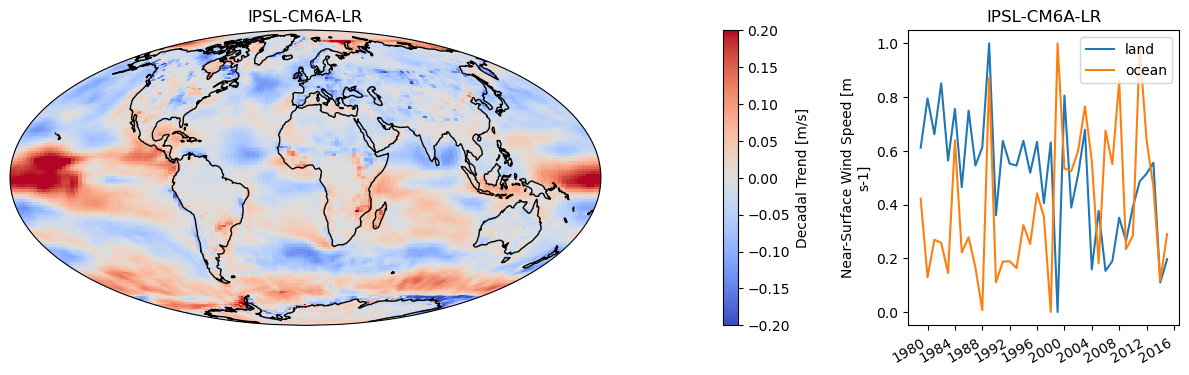

In [ ]:
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0

fig = plt.figure(figsize=(14, int(n_models*3)), constrained_layout=True)
gs = fig.add_gridspec(n_models, 2, width_ratios=[3, 1])

for i, k in enumerate(tqdm(model_names, desc='Plotting models')):
    # Name of model
    # name = k.split('.')[2]
    name=k
    # map axis
    map = fig.add_subplot(gs[i, 0], projection=ccrs.Mollweide())
    # timeseries axis
    ts = fig.add_subplot(gs[i, 1])
    # Get member
    ds = dset_dict[k]  # rename to work with xclim ensembles
    ds = ds.cf.sel(T=slice('1978', None))  # 1978-2014
    # Reduce the dataset
    da = ensemble_mean_std_max_min(ds)
    # Extract eastward wind
    sfcWind = da['sfcWind_mean']
    # Plot map
    trend = (
        sfcWind.cf.groupby('T.year').mean()
        .polyfit('year', deg=1, skipna=True)
        .polyfit_coefficients.sel(degree=1)*10  # decadal
    )
    im = trend.plot(ax=map, vmin=-0.2, vmax=0.2, cmap='coolwarm', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.15)
    cb.set_label(label='Decadal Trend [m/s]')
    # Mask data
    land_mask = land_region.mask(sfcWind.cf['X'], sfcWind.cf['Y'])
    land = sfcWind.where(land_mask == 0)
    ocean = sfcWind.where(land_mask != 0)
    # Plot time series (normalize data to compare)
    l_ts = land.cf.resample(T='1Y').mean().mean(['lat','lon'])
    ((l_ts-l_ts.min())/(l_ts.max()-l_ts.min())).plot(label='land')
    o_ts = ocean.cf.resample(T='1Y').mean().mean(['lat','lon'])
    ((o_ts-o_ts.min())/(o_ts.max()-o_ts.min())).plot(label='ocean')
    # Map plot options
    map.coastlines()
    map.set_title(name)
    # Time series plot options
    ts.set_title(name)
    ts.set_xlabel('')
    ts.legend(loc='upper right')
    break

plt.show()